Julia notebook kernel

# Wave equation 2d

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2}(x,y,t) - \left( \frac{\partial^2 u}{\partial x^2}(x,y,t) + \frac{\partial^2 u}{\partial y^2}(x,y,t) \right) = 0
\end{equation}
$$

Source: https://beltoforion.de/en/recreational_mathematics/2d-wave-equation.php

Also source: https://elar.urfu.ru/bitstream/10995/31219/1/978-5-7996-1342-6_2014.pdf
В. Г. Пименов, А. Б. Ложников ЧИСЛЕННЫЕ МЕТОДЫ В двух частях Часть 2 2014г. стр 87

TODO: absorbing boundary condition https://encyclopediaofmath.org/wiki/Absorbing_boundary_conditions

$$
\partial_t^2 u = \Delta u = \nabla^2 u
$$

The discrete version
$$
\begin{equation}
\partial_t^2 u^{(1)}_{i,j} = \frac{u^{(0)}_{i,j} - 2 u^{(1)}_{i,j} + u^{(2)}_{i,j}}{\tau^2}
\end{equation}
$$

The discrete version of the two-dimensional Laplace operator
$$
\begin{equation}		
		\quad \mathbf{D}^2_{i,j}=\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}
\end{equation}
$$
$$
\begin{equation}
	\Delta u^{(1)}_{i,j} = \frac{u^{(1)}_{i-1,j}+u^{(1)}_{i+1,j}+u^{(1)}_{i,j-1}+u^{(1)}_{i,j+1} - 4 u^{(1)}_{i,j}}{h^2}
\end{equation}
$$

Solution is
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( u^{(k)}_{i-1,j}+u^{(k)}_{i+1,j}+u^{(k)}_{i,j-1}+u^{(k)}_{i,j+1} - 4 u^{(k)}_{i,j} \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$
$$
\begin{equation}
	u^{(k+1)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left( \mathbf{D}^2_{i,j} u \right) + 2 u^{(k)}_{i,j} -  u^{(k-1)}_{i,j}
\end{equation}
$$

In [41]:
τ = 0.005
h = 0.01

@assert (τ/h)^2 <= 1 # * условие сходимости

Threads.nthreads()

8

#### Use more accurate spatial derivatives

$O(h^4)$:
$$
\begin{equation}
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{12}\begin{bmatrix}0 & 0 & -1 & 0 & 0\\0 & 0 & 16 & 0 & 0\\-1 & 16 & -60 & 16 & -1\\0 & 0 & 16 & 0 & 0\\0 & 0 & -1 & 0 & 0\end{bmatrix}
\end{equation}
$$

$O(h^6)$:
$$
\begin{equation}		
		\nonumber
		\mathbf{D}^2_{(i,j)}=\frac{1}{180}\begin{bmatrix}0 & 0 & 0 & 2 & 0 & 0 & 0\\0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 270 & 0 & 0 & 0\\2 & -27 & 270 & -980 & 270 & -27 & 2\\ 0 & 0 & 0 & 270 & 0 & 0 & 0\\ 0 & 0 & 0 & -27 & 0 & 0 & 0\\0 & 0 & 0 & 2 & 0 & 0 & 0\end{bmatrix}
\end{equation}
$$

A version of the difference equation with a location derivative term of error order $O(h^4)$ looks like this:
$$
\begin{equation}
	u^{(0)}_{i,j} = \left( \frac{\tau}{h}\right)^2 \left(-u^{(1)}_{i,j-2}+16u^{(1)}_{i,j-1}-u^{(1)}_{i-2,j}+16u^{(1)}_{i-1,j}-60u^{(1)}_{i,j}+16u^{(1)}_{i+1,j}-u^{(1)}_{i+2,j}+16u^{(1)}_{i,j+1}-u^{(1)}_{i,j+2}  \right) + 2 u^{(1)}_{i,j} -  u^{(2)}_{i,j}
\end{equation}
$$

In [73]:
xx = 0:h:1
yy = xx
N = length(xx)

at = (u_xy) -> (i, j) -> begin
  # * нулевые заграничные условия
  if i < 1 || i > N || j < 1 || j > N
    return 0
  end
  u_xy[i, j]
end
# at = (u_xy) -> (i, j) -> begin
#   # * топология тора в плоскости xy
#   # * волны складываются и амплитуда бесконечно возрастает
#   ii = mod(i, N) + 1
#   jj = mod(j, N) + 1
#   u_xy[ii,jj]
# end

D2_h2 = (u_xy) -> (i, j) -> begin
  v = at(u_xy)
  d = v(i - 1, j) + v(i + 1, j) + v(i, j - 1) + v(i, j + 1) - 4 * v(i, j)
  d
end

D2_h4 = (u_xy) -> (i, j) -> begin
  v = at(u_xy)
  d = -v(i, j - 2) + 16v(i, j - 1) - v(i - 2, j) + 16v(i - 1, j) - 60v(i, j) + 16v(i + 1, j) - v(i + 2, j) + 16v(i, j + 1) - v(i, j + 2)
  d
end

#252 (generic function with 1 method)

Начальнаые условия:
$$
\partial_t^2 u - \partial_x^2 u - \partial_y^2 u= 0
$$
$$
u(0,x,y) = \phi(x,y), \,\,\, \partial_t u |_{t=0} = \psi(x, y)
$$

In [96]:
import .Threads: @threads

function solve(; ϕ, ψ, T=1, D2=D2_h2)
  x = i -> xx[i]
  y = j -> yy[j]

  tt = 0:τ:T
  Nt = length(tt)

  u = zeros(N, N, Nt)
  @threads for i in 1:N
    for j in 1:N
      u[i, j, 1] = ϕ(x(i), y(j))
      u[i, j, 2] = u[i, j, 1] + τ * ψ(x(i), y(j))
    end
  end

  σ = (τ / h)^2

  for k in 2:Nt-1
    u_xy = u[:,:,k]
    @threads for i in 1:N
      for j in 1:N
        v = -u[i, j, k-1] + 2 * u[i, j, k] + σ * D2(u_xy)(i, j)
        u[i, j, k+1] = v
      end
    end
  end

  u
end

solve (generic function with 1 method)

In [75]:
import Plots: @gif

function plot3d(u_xy)
  Plots.surface(xx, yy, u_xy)
end

function anim(u)
  Nt = size(u)[end]
  gif = @gif for k in 1:Nt
    plot3d(u[:,:,k])
  end
  return gif
end

anim (generic function with 1 method)

In [97]:
import LinearAlgebra as Lin
u = begin
  fn = (x) -> abs(x) < 1 ? -x^2+1 : 0

  u0 = (x,y) -> fn(16 * Lin.norm([x y] - [1/2 1/2]))
  v0 = (x,y) -> 0
  solve(ϕ = u0, ψ = v0; T = 1)
end
size(u)

(101, 101, 201)

[ Info: Saved animation to d:\_docs\__math\__julia\src\samples\tmp.gif


Plots.AnimatedGif("d:\\_docs\\__math\\__julia\\src\\samples\\tmp.gif")
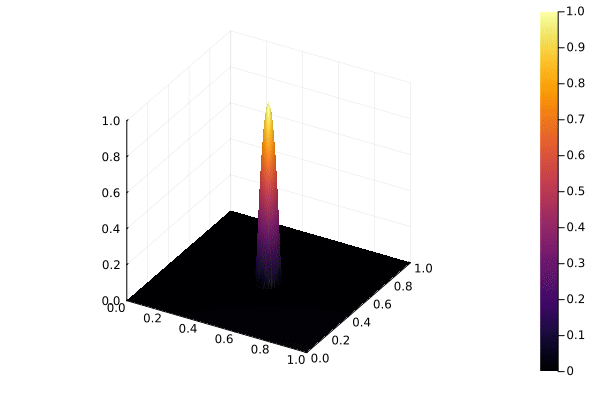

In [94]:
anim(u)